In [2]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [4]:
%run ../common_code.ipynb

In [5]:
data = pd.read_csv("../../datasets/abalone.data", sep=',', names=['sex', 'length', 'diameter', 'height', 'W_weight', 'S_weight', 'viscera_weight', 'shell_weight', 'rings'])
data.drop(columns=["sex"], inplace=True)
n_features = data.shape[1]-1
n = data.shape[0]
target = "rings"
features = data.columns.difference([target]).tolist()

data.head(10)

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


In [6]:
#data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))
#preprocessing
data = data[data["height"]<0.26]

## Using gradient boosting regressor for experiments

In [7]:
model = GradientBoostingRegressor(n_estimators=30,)
model.fit(data[features], data[target])

GradientBoostingRegressor(n_estimators=30)

## calculating individual errors

In [8]:
data_errors = data.copy(deep=True)
data_errors["ape_error"] = np.abs((data[target]-model.predict(data[features]))/data[target])
data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,ape_error
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.423826
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.074583
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.177560
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.023819
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.009314


## discretization into gradarions

In [9]:
disc_data, pipeline_data = discretize(data_errors, features+["ape_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,S_weight,W_weight,diameter,height,length,shell_weight,viscera_weight,ape_error
0,0,0,1,0,1,0,0,1
1,0,0,0,0,0,0,0,0
2,0,1,1,1,1,1,0,0
3,0,0,1,1,1,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
4170,1,1,2,2,2,1,1,0
4171,1,1,2,1,2,1,1,0
4172,1,1,2,2,2,1,2,0
4173,1,1,2,1,2,1,1,0


In [10]:
pipeline_data["cont_features"]

['length',
 'diameter',
 'height',
 'W_weight',
 'S_weight',
 'viscera_weight',
 'shell_weight',
 'ape_error']

## automatic adjustment of gradations
for features with unfair gradations kmeans split
in general gradations are up to reseacher reasoning

In [11]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
#dicval
v = pipeline_data["cont_features_edges"]
for i in [7]:
    v[i] = [v[i][0], dicval[pipeline_data["cont_features"][i]][3], dicval[pipeline_data["cont_features"][i]][7],
            v[i][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

## rediscretization after the adjustment

In [12]:
disc_data = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=data_errors.columns)
disc_data

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,ape_error
0,1,1,0,0,0,0,0,2
1,0,0,0,0,0,0,0,1
2,1,1,1,1,0,0,1,1
3,1,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
4170,2,2,2,1,1,1,1,0
4171,2,2,1,1,1,1,1,0
4172,2,2,2,1,1,2,1,1
4173,2,2,1,1,1,1,1,0


In [13]:
disc_data['ape_error'].value_counts()

ape_error
1    1668
2    1256
0    1251
Name: count, dtype: int64

In [14]:
current_error = data_errors["ape_error"].sum()/n
current_error

0.15496210534140759

In [15]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore


In [16]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'length': 3,
 'diameter': 3,
 'height': 3,
 'W_weight': 3,
 'S_weight': 3,
 'viscera_weight': 3,
 'shell_weight': 3,
 'ape_error': 3}

In [17]:
bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("ape_error", x) for x in features]

In [18]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [19]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,S_weight,Discrete,disc,[],[]
1,W_weight,Discrete,disc,[S_weight],[disc]
2,ape_error,Discrete,disc,[S_weight],[disc]
3,length,Discrete,disc,"[W_weight, S_weight]","[disc, disc]"
4,diameter,Discrete,disc,"[length, W_weight]","[disc, disc]"
5,viscera_weight,Discrete,disc,"[length, W_weight]","[disc, disc]"
6,shell_weight,Discrete,disc,"[diameter, W_weight]","[disc, disc]"
7,height,Discrete,disc,"[diameter, shell_weight]","[disc, disc]"


In [20]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [21]:
bn.distributions

{'S_weight': {'cprob': [0.42347305389221557,
   0.40119760479041916,
   0.17532934131736527],
  'vals': ['0', '1', '2']},
 'W_weight': {'cprob': {"['0']": [0.9276018099547512,
    0.07239819004524888,
    0.0],
   "['1']": [0.060298507462686564, 0.8740298507462687, 0.06567164179104477],
   "['2']": [0.0, 0.1721311475409836, 0.8278688524590164]},
  'vals': ['0', '1', '2']},
 'ape_error': {'cprob': {"['0']": [0.25961538461538464,
    0.3897058823529412,
    0.3506787330316742],
   "['1']": [0.3182089552238806, 0.3970149253731343, 0.2847761194029851],
   "['2']": [0.35382513661202186, 0.42896174863387976, 0.21721311475409835]},
  'vals': ['0', '1', '2']},
 'length': {'cprob': {"['0', '0']": [0.4353658536585366,
    0.5634146341463414,
    0.0012195121951219512],
   "['0', '1']": [0.04950495049504951,
    0.9306930693069307,
    0.019801980198019802],
   "['0', '2']": [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
   "['1', '0']": [0.0, 0.9375, 0.0625],
   "['1', '1']": [0.0

## applying YODO

In [22]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

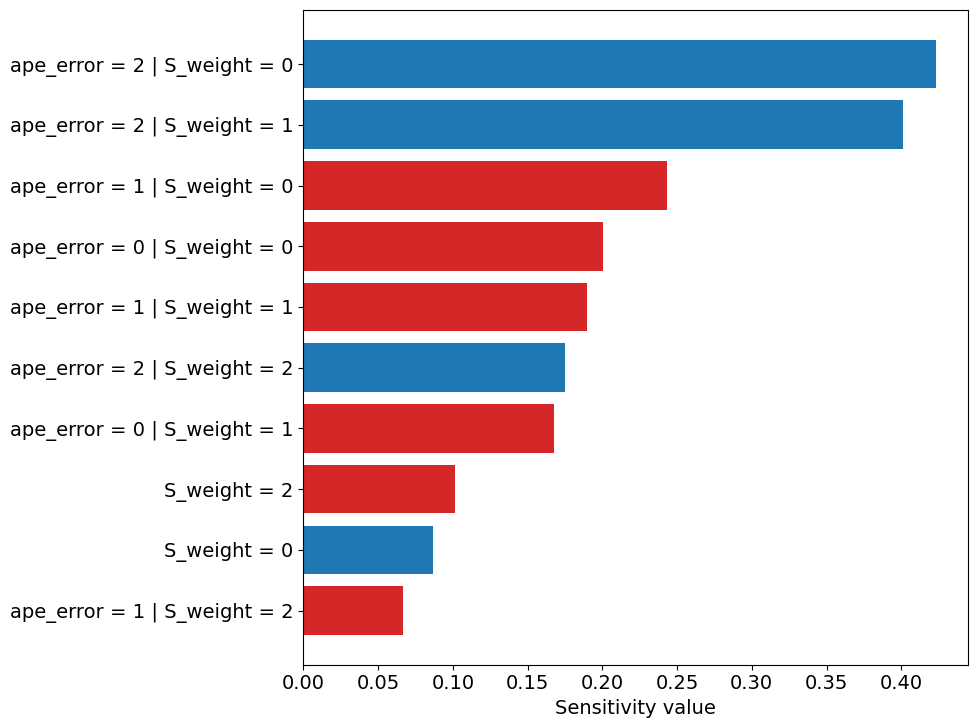

In [23]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'ape_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии низкого S_weight

In [24]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as mape

In [25]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

## applying SHAP

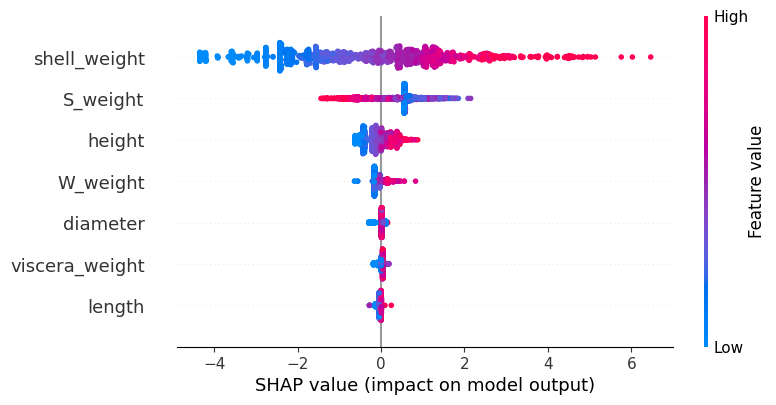

In [26]:
explainer = shap.Explainer(model)
shap_values = explainer(data.reset_index()[disc_data['ape_error']==2][features])
shap.plots.beeswarm(shap_values)

трактование: больше всего на предскзаания для наблюдений с высокой ошибкой влияет shell_weight, большее влияние от высоких значений (влияние на результат, дающий высокую ошибку)

## applying our approarch

In [ ]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,length_0,length_1,length_2,diameter_0,diameter_1,diameter_2,height_0,height_1,height_2,W_weight_0,...,S_weight_2,viscera_weight_0,viscera_weight_1,viscera_weight_2,shell_weight_0,shell_weight_1,shell_weight_2,ape_error_0,ape_error_1,ape_error_2
0,0,1,0,0,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
1,1,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
2,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,1,0,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
4,1,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
4171,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
4172,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,1,0
4173,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0


In [ ]:
from itertools import product

In [ ]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "ape_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "ape_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2025-03-22 16:45:37,965 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 16:45:37,968 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 16:45:37,969 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 16:45:37,971 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 16:45:37,972 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 16:45:37,973 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 16:45:37,975 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 16:45:37,976 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 16:45:37,977 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 16:45:37,978 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,height_0,Discrete,disc,[],[]
1,ape_error_1,Discrete,disc,[],[]
2,length_1,Discrete,disc,[height_0],[disc]
3,diameter_1,Discrete,disc,[length_1],[disc]
4,length_0,Discrete,disc,"[diameter_1, height_0]","[disc, disc]"
5,diameter_0,Discrete,disc,"[length_0, height_0]","[disc, disc]"
6,length_2,Discrete,disc,"[diameter_0, diameter_1]","[disc, disc]"
7,diameter_2,Discrete,disc,"[length_2, height_0]","[disc, disc]"
8,shell_weight_0,Discrete,disc,"[length_2, diameter_2, height_0]","[disc, disc, disc]"
9,W_weight_0,Discrete,disc,"[length_2, height_0, shell_weight_0]","[disc, disc, disc]"


In [ ]:
info = gbn.get_info()
info.iloc[12, 3]

['S_weight_0']

In [ ]:
gbn.custom_mapper

In [ ]:
gbn.plot("abalone_regr.html")

In [27]:
dfeat = ["S_weight"] # yodo suggestion
dcat = [0]

dfeatshap = ['shell_weight']
dcatshap = [2]

dfeatbn = ["S_weight"]
dcatbn = [0]

d_dict={
    'yodo': [["S_weight"], [0]],
    'bn': [['shell_weight'], [2]],
    'shap': [["S_weight"], [0]]
}

bn = n


In [28]:
data.shape

(4175, 8)

## run 1: alpha=0.5 (preserve half)

In [146]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [lambda x, y: mape(x, y)*100, 
                                    lambda x, y: r2_score(x, y)*100], trials=250,alpha=0.5, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='regr',
                                    incl_test=True,
                                    test_size=0.25,
                                    stratify_tts=False)

100%|██████████| 250/250 [09:26<00:00,  2.27s/it]


In [147]:
stats_res['avg_n_dropped']

{'yodo': 186.824, 'bn': 170.68, 'shap': 186.824, 'init': -1, 'random': -1}

In [148]:
{k: v/n for k, v in stats_res['avg_n_dropped'].items()}

{'yodo': 0.044726837443141015,
 'bn': 0.040861862580799616,
 'shap': 0.044726837443141015,
 'init': -0.00023940627244433804,
 'random': -0.00023940627244433804}

In [82]:
def plot_scores(metrics, graph_label, k):
    avg_metric = {}
    for name in metrics.keys():
        sns.histplot(metrics[name][k], label=names_mapping[name], bins=25)
        avg_metric[names_mapping[name]] = sum(metrics[name][k])/len(metrics[name][k])

    plt.legend()
    plt.xlabel(graph_label)
    return avg_metric

names_mapping = {k:v for k, v in
                        zip(['init', 'yodo', 'bn', 'shap', 'random'],
                        ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ])}

In [83]:
def extended_experiments_output(stats_dictionary, metrics_labels_list):
    tbl_scores = pd.DataFrame(columns=['method', 'metric', 'value'])
    i=0
    for k, label in enumerate(metrics_labels_list):
        plt.figure()
        avg_stats = plot_scores(stats_dictionary, label, k)
        for key, val in avg_stats.items():
            tbl_scores.loc[i, :] = [key, label, val]
            i+=1
    return pd.pivot(tbl_scores, index='metric', columns='method')


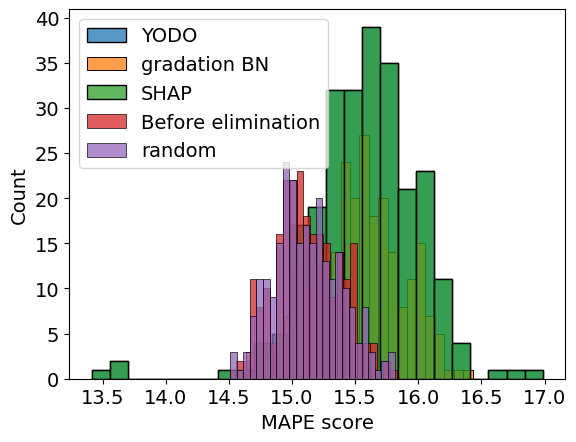

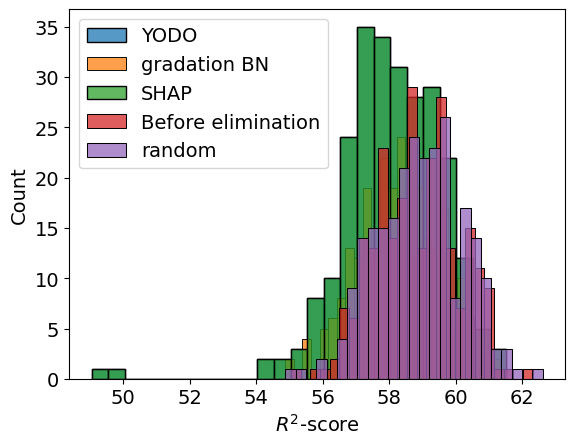

In [84]:
res_train_tbl = extended_experiments_output(stats_res['metrics'], ['MAPE score', '$R^2$-score'])

In [85]:
res_train_tbl

value                                              
method      Before elimination       SHAP       YODO gradation BN     random
metric                                                                      
$R^2$-score           58.82638  58.086707  58.086695    58.226936  58.919227
MAPE score           15.123503  15.573654  15.573594    15.530744  15.115476

In [86]:
print(res_train_tbl.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 58.826380 & 58.086707 & 58.086695 & 58.226936 & 58.919227 \\
MAPE score & 15.123503 & 15.573654 & 15.573594 & 15.530744 & 15.115476 \\
\bottomrule
\end{tabular}



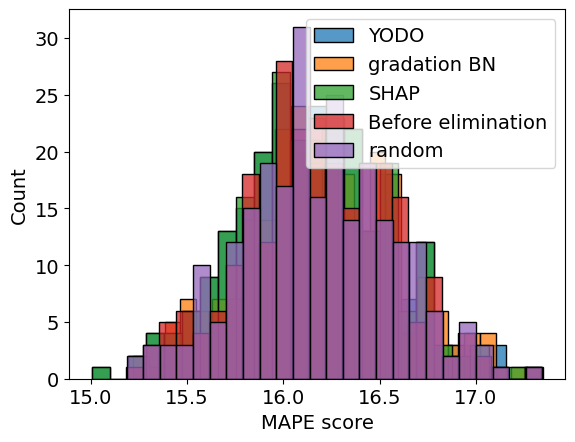

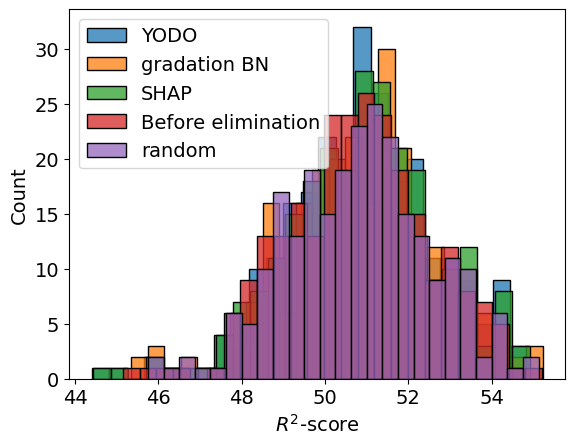

In [87]:
res_test_tbl = extended_experiments_output(stats_res['metrics_test'], ['MAPE score', '$R^2$-score'])

In [88]:
res_test_tbl

value                                              
method      Before elimination       SHAP       YODO gradation BN     random
metric                                                                      
$R^2$-score          50.782976  50.849201  50.851613    50.869322  50.787567
MAPE score           16.181556   16.14589  16.151339     16.19442  16.184907

In [155]:
print(res_test_tbl.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 50.782976 & 50.849201 & 50.851613 & 50.869322 & 50.787567 \\
MAPE score & 16.181556 & 16.145890 & 16.151339 & 16.194420 & 16.184907 \\
\bottomrule
\end{tabular}



In [99]:
def avg_prcnt_change(stats, name1, name2, metric_num, direction=1):
    cnt = len(stats[name1][0])
    return direction*sum((a-b)/b for a, b in zip(stats[name1][metric_num], stats[name2][metric_num]))/cnt*100

In [152]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1) #

-0.07973427354496974

In [154]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, 1)

0.17402048116275692

In [72]:
from scipy.stats import ttest_rel

In [156]:
ttest_rel(stats_res['metrics']['bn'][0], stats_res['metrics']['init'][0]) #['MAPE score', '$R^2$-score']

TtestResult(statistic=27.34766283742486, pvalue=5.757302968971751e-77, df=249)

In [157]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])#['MAPE score', '$R^2$-score']

TtestResult(statistic=2.422722370247869, pvalue=0.01611890902972461, df=249)

In [158]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])#['MAPE score', '$R^2$-score']

TtestResult(statistic=1.6554978760694838, pvalue=0.09908328499825067, df=249)

In [159]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['random'][1])#['MAPE score', '$R^2$-score']

TtestResult(statistic=1.5595472379404618, pvalue=0.1201369657916023, df=249)

## Run 2: alpha=0.7

In [119]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [lambda x, y: mape(x, y)*100, 
                                    lambda x, y: r2_score(x, y)*100], trials=250,alpha=0.7, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='regr',
                                    incl_test=True,
                                    test_size=0.25,
                                    stratify_tts=False)

100%|██████████| 250/250 [10:05<00:00,  2.42s/it]


In [121]:
stats_res['avg_n_dropped']

{'yodo': 132.428, 'bn': 103.388, 'shap': 132.428, 'init': -1, 'random': -1}

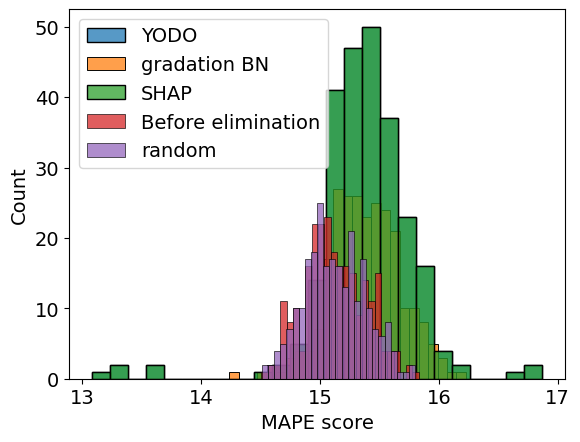

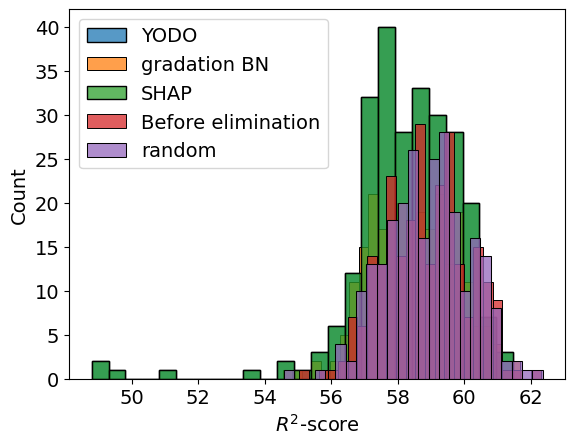

In [122]:
res_train_tbl_1 = extended_experiments_output(stats_res['metrics'], ['MAPE score', '$R^2$-score'])

In [123]:
res_train_tbl_1

value                                              
method      Before elimination       SHAP       YODO gradation BN     random
metric                                                                      
$R^2$-score           58.82638  58.259432  58.259478    58.448882  58.892793
MAPE score           15.123503  15.376014  15.376034    15.376645  15.122498

In [127]:
print(res_train_tbl_1.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 58.826380 & 58.259432 & 58.259478 & 58.448882 & 58.892793 \\
MAPE score & 15.123503 & 15.376014 & 15.376034 & 15.376645 & 15.122498 \\
\bottomrule
\end{tabular}



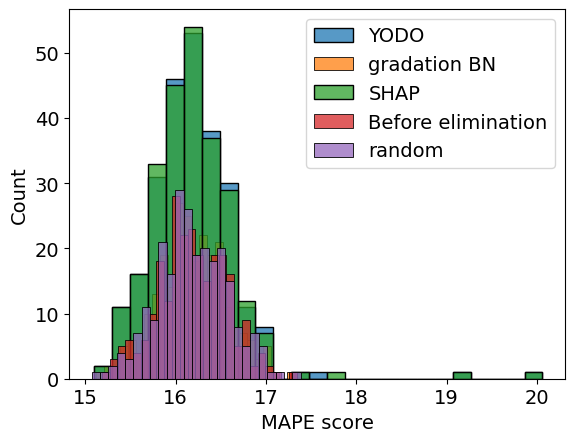

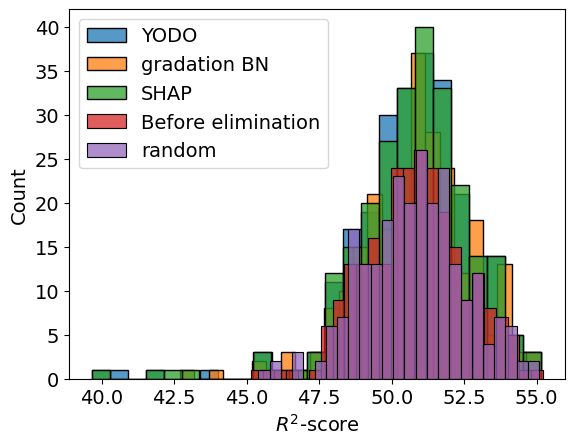

In [125]:
res_test_tbl_1 = extended_experiments_output(stats_res['metrics_test'], ['MAPE score', '$R^2$-score'])

In [126]:
res_test_tbl_1

value                                              
method      Before elimination       SHAP       YODO gradation BN     random
metric                                                                      
$R^2$-score          50.782976  50.688406  50.682663    50.785901  50.776947
MAPE score           16.181556  16.189546  16.191987    16.176929  16.184443

In [128]:
print(res_test_tbl_1.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 50.782976 & 50.688406 & 50.682663 & 50.785901 & 50.776947 \\
MAPE score & 16.181556 & 16.189546 & 16.191987 & 16.176929 & 16.184443 \\
\bottomrule
\end{tabular}



In [ ]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0)#['MAPE score', '$R^2$-score']

-0.02853160666730992

In [ ]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)#['MAPE score', '$R^2$-score']

-0.006480115681487938

In [132]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])

TtestResult(statistic=-1.0670543825901544, pvalue=0.28698075243179677, df=249)

In [133]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])

TtestResult(statistic=0.05039050080711232, pvalue=0.959851604027029, df=249)

## Run 3: alpha=0.4

In [134]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [lambda x, y: mape(x, y)*100, 
                                    lambda x, y: r2_score(x, y)*100], trials=250,alpha=0.4, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='regr',
                                    incl_test=True,
                                    test_size=0.25,
                                    stratify_tts=False)

100%|██████████| 250/250 [09:23<00:00,  2.26s/it]


In [135]:
stats_res['avg_n_dropped']

{'yodo': 230.416, 'bn': 221.996, 'shap': 230.416, 'init': -1, 'random': -1}

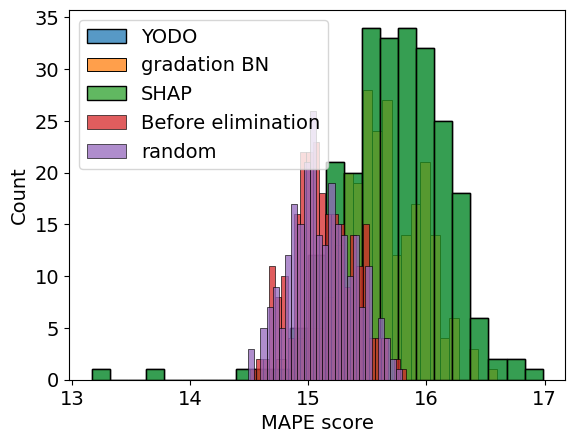

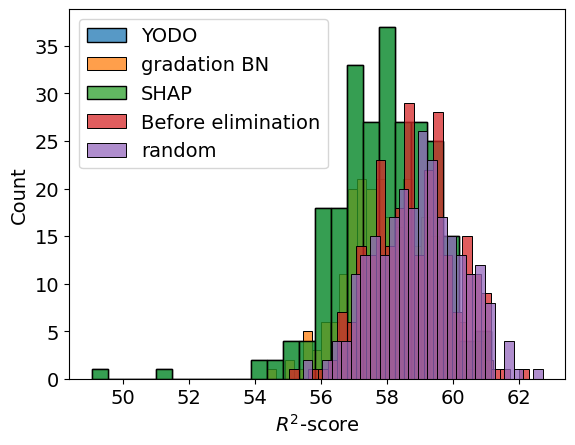

In [136]:
res_train_tbl_2 = extended_experiments_output(stats_res['metrics'], ['MAPE score', '$R^2$-score'])

In [137]:
res_train_tbl_2

value                                              
method      Before elimination       SHAP       YODO gradation BN     random
metric                                                                      
$R^2$-score           58.82638  57.889382  57.889382     58.10997  58.960487
MAPE score           15.123503  15.715921  15.715924    15.618497  15.111626

In [138]:
print(res_train_tbl_2.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 58.826380 & 57.889382 & 57.889382 & 58.109970 & 58.960487 \\
MAPE score & 15.123503 & 15.715921 & 15.715924 & 15.618497 & 15.111626 \\
\bottomrule
\end{tabular}



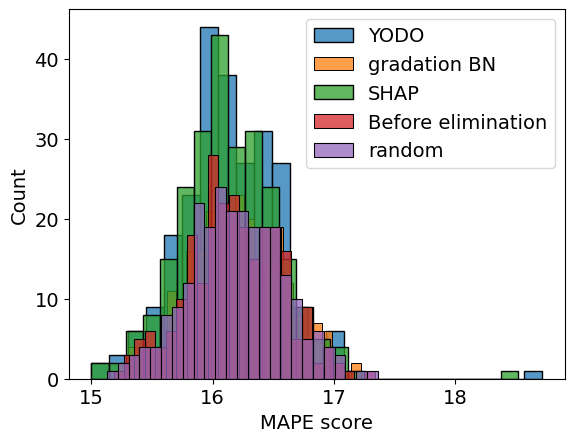

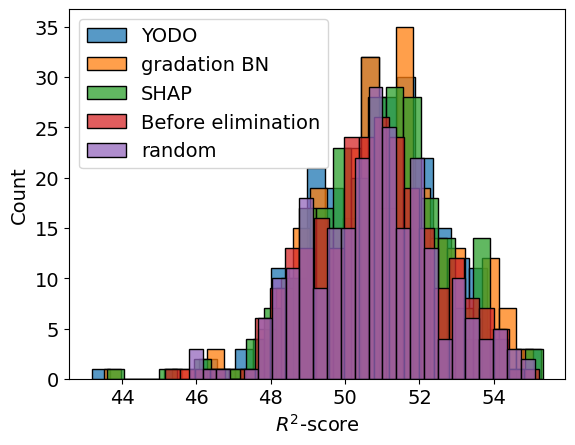

In [139]:
res_test_tbl_2 = extended_experiments_output(stats_res['metrics_test'], ['MAPE score', '$R^2$-score'])

In [140]:
res_test_tbl_2

value                                              
method      Before elimination       SHAP       YODO gradation BN     random
metric                                                                      
$R^2$-score          50.782976  50.883319  50.883858    50.917988  50.740377
MAPE score           16.181556  16.137937   16.14151    16.215501  16.195845

In [141]:
print(res_test_tbl_2.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 50.782976 & 50.883319 & 50.883858 & 50.917988 & 50.740377 \\
MAPE score & 16.181556 & 16.137937 & 16.141510 & 16.215501 & 16.195845 \\
\bottomrule
\end{tabular}



In [142]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0)#['MAPE score', '$R^2$-score']

0.2100764607582261

In [143]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)#['MAPE score', '$R^2$-score']

-0.26937294820647073

In [144]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])

TtestResult(statistic=5.144309428117122, pvalue=5.443539461159072e-07, df=249)

In [145]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])

TtestResult(statistic=2.7511220911709673, pvalue=0.006375435596537772, df=249)